In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns 

import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import (roc_auc_score, f1_score, confusion_matrix, 
                             classification_report, roc_curve, ConfusionMatrixDisplay, 
                             accuracy_score, make_scorer, recall_score, precision_recall_curve)

<i>Load data

In [2]:
df = pd.read_csv('data/audio_features_df.csv')
df.head()

,user_name,gender,age_range,language,dialect,mean_freq_khz,peak_freq_khz,std_freq_khz,median_freq_khz,q1_freq_khz,q3_freq_khz,iqr_freq_khz,skewness,kurtosis,mode_freq_khz
0,1028,male,adult,en,american english,1.322874,0.484375,0.050027,0.156250,0.125000,0.210938,0.085938,0.229037,-1.247624,0.125000
1,1028,male,adult,en,american english,1.314869,0.101562,0.052185,0.164062,0.109375,0.210938,0.101562,0.061372,-1.469203,0.101562
2,1028,male,adult,en,american english,1.314457,0.421875,0.049979,0.164062,0.117188,0.210938,0.093750,-0.023563,-1.396101,0.203125
3,1337ad,female,adult,en,other,1.152873,0.007812,0.050835,0.203125,0.148438,0.226562,0.078125,-0.737347,-0.783785,0.210938
4,1337ad,female,adult,en,other,0.758118,0.007812,0.057454,0.179688,0.109375,0.226562,0.117188,-0.078516,-1.569696,0.226562


#### Limitations from the data we extract

1. We only consider 3 samples for each folder of audio files.
2. Considered only wav audio files.

In [3]:
df.shape

(18614, 15)

### Dependent variable

---

In [4]:
df['gender'].value_counts()

gender
male             16523
female            1272
male;              324
[male];            198
[female];           90
please select       69
unknown             60
no_gender           45
masculino           12
männlich             9
weiblich             3
make                 3
adult                3
masculin             3
Name: count, dtype: int64

Since there are lot of categories pertaining to men and women gender, our goal is to mapped out these values correctly. 

- "male;", "[male];", "masculino", "männlich", "masculin" → "male"
- "female;", "[female];", "weiblich" → "female"

We will also filter out unclear and related variables, good thing that they are few.

- please select, unknown, no_gender, make, adult

In [5]:
# Let us clean them out
remove_gender_rows = ["please select", "unknown", "no_gender", "make", "adult"]

print(f"Original df: {df.shape[0]} rows")
df = df.loc[~df['gender'].isin(remove_gender_rows),:]
print(f"filtered df: {df.shape[0]} rows")

gender_mapping = {
    "male": "male",
    "male;": "male",
    "[male];": "male",
    "masculino": "male",
    "männlich": "male",
    "masculin": "male",
    "female": "female",
    "female;": "female",
    "[female];": "female",
    "weiblich": "female"
}
print('== NEW MAPPED GENDER ==')
print('======= COUNTS ========')
df['gender'] = df['gender'].map(gender_mapping)
print(df['gender'].value_counts())
print('======= PCT ========')
print(round(100*df['gender'].value_counts()/df.shape[0],2))

Original df: 18614 rows
filtered df: 18434 rows
== NEW MAPPED GENDER ==
======= COUNTS ========
gender
male      17069
female     1365
Name: count, dtype: int64
======= PCT ========
gender
male      92.6
female     7.4
Name: count, dtype: float64


### Independent Variables (Audio)

---

In [6]:
audio_feats = ['mean_freq_khz', 'peak_freq_khz', 'median_freq_khz', 'q1_freq_khz', 'q3_freq_khz', 'iqr_freq_khz', 'skewness', 'kurtosis', 'mode_freq_khz']
df[audio_feats].head()

,mean_freq_khz,peak_freq_khz,median_freq_khz,q1_freq_khz,q3_freq_khz,iqr_freq_khz,skewness,kurtosis,mode_freq_khz
0,1.322874,0.484375,0.156250,0.125000,0.210938,0.085938,0.229037,-1.247624,0.125000
1,1.314869,0.101562,0.164062,0.109375,0.210938,0.101562,0.061372,-1.469203,0.101562
2,1.314457,0.421875,0.164062,0.117188,0.210938,0.093750,-0.023563,-1.396101,0.203125
3,1.152873,0.007812,0.203125,0.148438,0.226562,0.078125,-0.737347,-0.783785,0.210938
4,0.758118,0.007812,0.179688,0.109375,0.226562,0.117188,-0.078516,-1.569696,0.226562


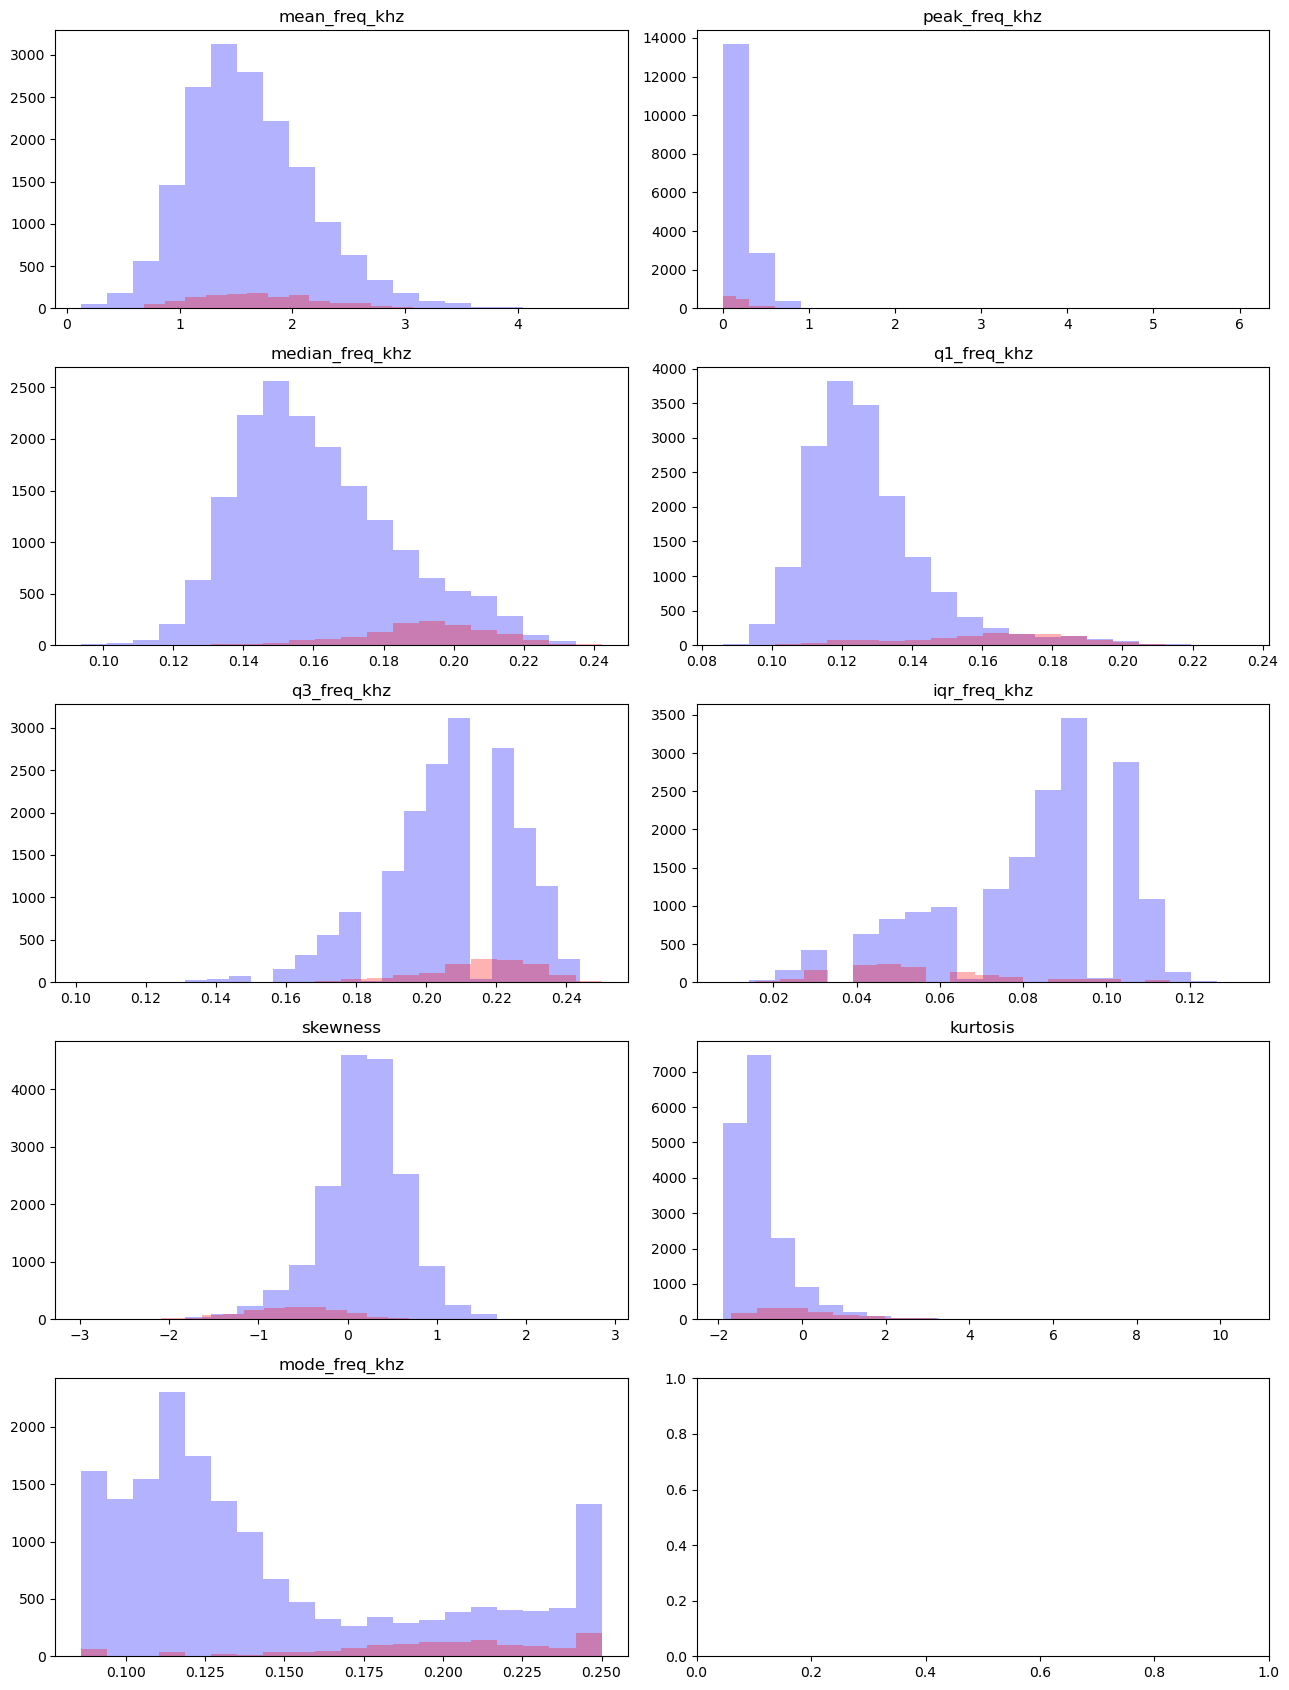

In [7]:
fig, axes = plt.subplots(5,2, figsize = (13,17))
ax = axes.ravel()

for i in range(len(audio_feats)):
    ax[i].hist(df.loc[df['gender'] == 'male',audio_feats[i]], bins = 20, color = 'blue', alpha = 0.3)
    ax[i].hist(df.loc[df['gender'] == 'female',audio_feats[i]], bins = 20, color = 'red', alpha = 0.3)
    ax[i].set_title(audio_feats[i], fontsize = 12)

fig.tight_layout()

#### About the audio features: 
<i>

- Heavy class imbalance among female and male groups are observed. 
- Even the frequency of female groups are lower, there has been observation for different distribution of data for features `median frequency`, `1st quartile frequency`, `3rd quartile freqency`, `skewness`,`interquartile range frequency`, `skewness` and `kurtosis`. 

#### Correlation 

- Measures the relationship between two variables, and what types and degrees of correlation exist

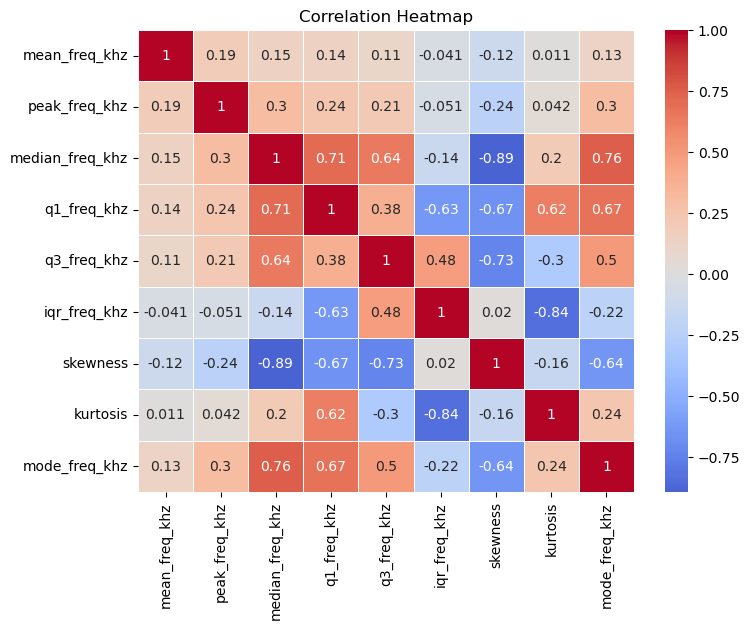

In [8]:
corr_df = df[audio_feats].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Feature Selection for Linear Model

---

In [9]:
# Split data

X = df[audio_feats]
y = df['gender'].map({'male':0, 'female':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.35, random_state=77)

Here are the following highly correlated_pairs:

In [10]:
corr_df = X.corr()
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
high_corr_pairs = upper_tri.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > threshold]
high_corr_pairs

,Feature1,Feature2,Correlation
15,median_freq_khz,q1_freq_khz,0.707996
18,median_freq_khz,skewness,-0.894730
20,median_freq_khz,mode_freq_khz,0.755035
27,q3_freq_khz,skewness,-0.729834
31,iqr_freq_khz,kurtosis,-0.840909


We have now an idea on what features to eliminate for feature selection using CORRELATION.
The goal is to remove features that are highly correlated while preserving unique information.

In [11]:
high_correlation_feats = ['median_freq_khz', 'skewness', 'iqr_freq_khz']

L1- Feature Selection

In [12]:
logreg_l1 = LogisticRegression(C = 0.05, penalty='l1', solver='liblinear', random_state=77)
select_model = SelectFromModel(estimator=logreg_l1).fit(X_train, y_train)
X_train.columns[select_model.get_support(indices=True)]

Index(['peak_freq_khz', 'skewness', 'kurtosis'], dtype='object')

We get the union of highly correlated features and features remove from L1 regularization, we now get:



In [13]:
removed_feats = list(set(high_correlation_feats + ['peak_freq_khz', 'skewness', 'kurtosis']))
final_feats_logreg = [feat for feat in X_train.columns if feat not in removed_feats]

final_feats_logreg

['mean_freq_khz', 'q1_freq_khz', 'q3_freq_khz', 'mode_freq_khz']

## Modeling

---

#### Logit Model

In [14]:
X_train[final_feats_logreg]

,mean_freq_khz,q1_freq_khz,q3_freq_khz,mode_freq_khz
868,1.279637,0.132812,0.171875,0.148438
11986,1.709124,0.109375,0.218750,0.109375
11009,1.001420,0.101562,0.179688,0.101562
11707,2.037962,0.125000,0.195312,0.132812
16672,2.503853,0.109375,0.179688,0.085938
...,...,...,...,...
13287,2.330923,0.101562,0.195312,0.101562
11386,1.400155,0.132812,0.226562,0.242188
14438,1.489189,0.125000,0.226562,0.125000
17712,1.452328,0.132812,0.218750,0.250000


In [15]:
logreg = sm.Logit(y_train, X_train[final_feats_logreg]).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.207019
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 gender   No. Observations:                11982
Model:                          Logit   Df Residuals:                    11978
Method:                           MLE   Df Model:                            3
Date:                Thu, 20 Mar 2025   Pseudo R-squ.:                  0.2156
Time:                        22:54:51   Log-Likelihood:                -2480.5
converged:                       True   LL-Null:                       -3162.5
Covariance Type:            nonrobust   LLR p-value:                1.978e-295
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mean_freq_khz    -0.3333      0.069     -4.820      0.000      -0.469      -0.198
q1_freq_khz      48.

### 

In [16]:
# Fit the model
mod_logreg = LogisticRegression(random_state=77)
mod_logreg.fit(X_train[final_feats_logreg], y_train)

LogisticRegression(random_state=77)

In [37]:
# Calculating Metrics in Training and Test
def calculate_metrics_training_and_test(X_train, y_train, X_test, y_test, model, title):
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]

    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_proba)
    train_f1 = f1_score(y_train, y_train_pred)

    test_auc = roc_auc_score(y_test, y_test_proba)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"Training metrics:")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"AUC-ROC: {train_auc:.4f}")
    print(f"F1-Score: {train_f1:.4f}")

    print(f"Test metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"AUC-ROC: {test_auc:.4f}")
    print(f"F1-Score: {test_f1:.4f}")

    plt.figure(figsize=(8, 4))

    # Train
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {train_auc:.4f})')
    # Test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['Male', 'Female'])
    disp.plot(cmap = plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=15, pad=20) 
    plt.xlabel('Prediction', fontsize=11) 
    plt.ylabel('Actual', fontsize=11)
    plt.show()

    print(classification_report(y_test, y_test_pred))

Training metrics:
Accuracy: 0.9202
AUC-ROC: 0.8552
F1-Score: 0.4310
Test metrics:
Accuracy: 0.9225
AUC-ROC: 0.8720
F1-Score: 0.4624


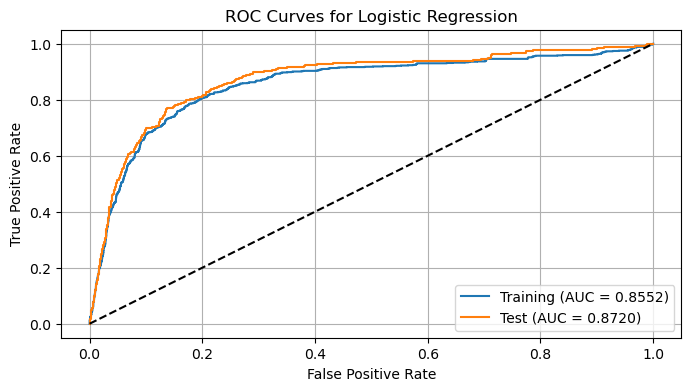

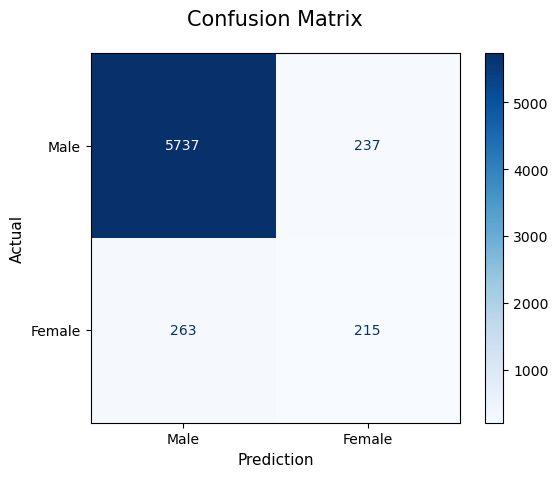

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5974
           1       0.48      0.45      0.46       478

    accuracy                           0.92      6452
   macro avg       0.72      0.71      0.71      6452
weighted avg       0.92      0.92      0.92      6452



In [38]:
calculate_metrics_training_and_test(X_train[final_feats_logreg], y_train, X_test[final_feats_logreg], y_test, mod_logreg, 'ROC Curves for Logistic Regression')

Upon fitting, our data seems to suffer in class imbalance predicting 0% of women class.

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
smote = SMOTE(random_state = 77, sampling_strategy=0.3)
X_train_res, y_train_res = smote.fit_resample(X_train[final_feats_logreg], y_train)

print("Original target")
print(y_train.value_counts())
print("SMOTEd")
print(y_train_res.value_counts())

Original target
gender
0    11095
1      887
Name: count, dtype: int64
SMOTEd
gender
0    11095
1     3328
Name: count, dtype: int64


In [21]:
mod_logreg = LogisticRegression(random_state=77)
mod_logreg.fit(X_train_res, y_train_res)

LogisticRegression(random_state=77)

Training metrics:
Accuracy: 0.8344
AUC-ROC: 0.8654
F1-Score: 0.5345
Test metrics:
Accuracy: 0.9225
AUC-ROC: 0.8720
F1-Score: 0.4624


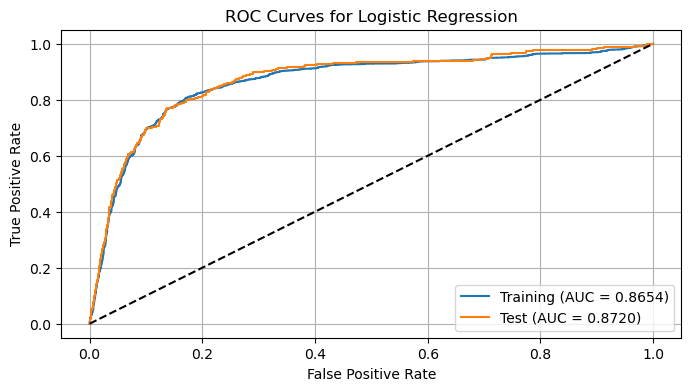

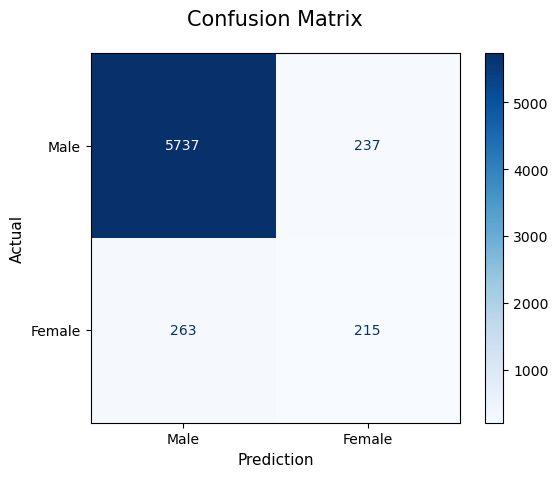

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5974
           1       0.48      0.45      0.46       478

    accuracy                           0.92      6452
   macro avg       0.72      0.71      0.71      6452
weighted avg       0.92      0.92      0.92      6452



In [39]:
calculate_metrics_training_and_test(X_train_res, y_train_res, X_test[final_feats_logreg], y_test, mod_logreg, 'ROC Curves for Logistic Regression')

Notes: 

<i>

- Implementing SMOTE gave us a decent amount of performance from f1-score as baseline metric for classifying gender male and female correctly than our initial fit.
- As percentage of SMOTE sampling increases, the model tends to overfit in terms of f1-score as basis.

### Random Forest Classifier

In [23]:
# Fitting the model to all features

rf_model = RandomForestClassifier(random_state=77)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=77)

Training metrics:
Accuracy: 1.0000
AUC-ROC: 1.0000
F1-Score: 1.0000
Test metrics:
Accuracy: 0.9445
AUC-ROC: 0.9369
F1-Score: 0.5480


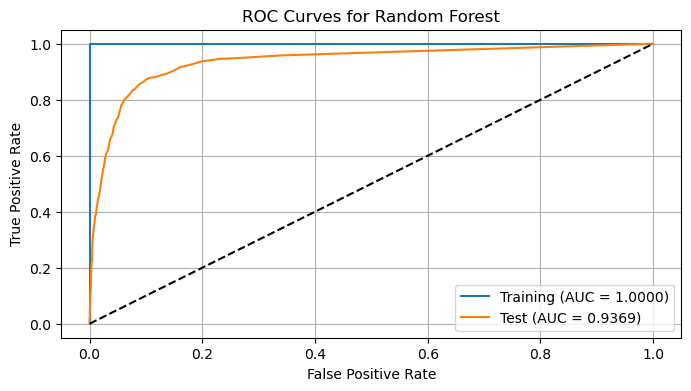

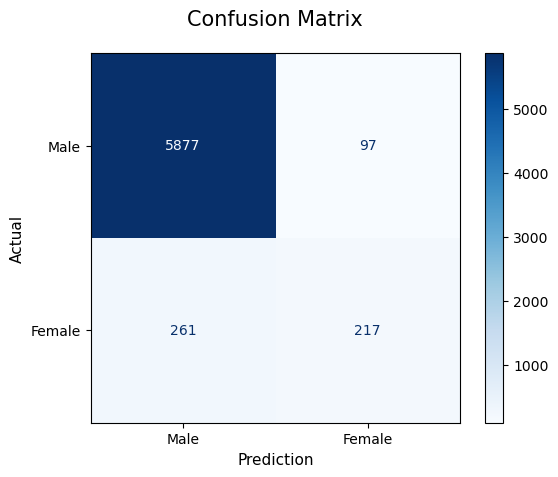

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5974
           1       0.69      0.45      0.55       478

    accuracy                           0.94      6452
   macro avg       0.82      0.72      0.76      6452
weighted avg       0.94      0.94      0.94      6452



In [40]:
calculate_metrics_training_and_test(X_train, y_train, X_test, y_test, rf_model, 'ROC Curves for Random Forest')

<i>
The model tends to overfit so we need to perform gridsearch in finding the best parameters to battle overfit and maximize f1-score of the female class.

##### Implementing GridSearch

In [25]:
params = {
    'n_estimators': [60, 120, 300],
    'max_depth': [3, 5], 
    'max_samples': [0.7, 0.9],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2', 0.7]
}

params

{'n_estimators': [60, 120, 300],
 'max_depth': [3, 5],
 'max_samples': [0.7, 0.9],
 'min_samples_split': [10, 20],
 'min_samples_leaf': [5, 10],
 'max_features': ['sqrt', 'log2', 0.7]}

In [26]:
rfm = RandomForestClassifier(random_state=77, criterion='gini', bootstrap=True)
gridsearch_rf = GridSearchCV(
    estimator=rfm, 
    param_grid=params, 
    cv = 5, 
    verbose=3, 
    scoring = make_scorer(f1_score, pos_label = 1, average = 'binary')
)

In [27]:
gridsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END max_depth=3, max_features=sqrt, max_samples=0.7, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=0.445 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=sqrt, max_samples=0.7, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=0.408 total time=   0.1s
[CV 3/5] END max_depth=3, max_features=sqrt, max_samples=0.7, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=0.498 total time=   0.1s
[CV 4/5] END max_depth=3, max_features=sqrt, max_samples=0.7, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=0.489 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=sqrt, max_samples=0.7, min_samples_leaf=5, min_samples_split=10, n_estimators=60;, score=0.454 total time=   0.1s
[CV 1/5] END max_depth=3, max_features=sqrt, max_samples=0.7, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=0.451 total time=   0.3s
[CV 2/5] END max_d

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=77),
             param_grid={'max_depth': [3, 5],
                         'max_features': ['sqrt', 'log2', 0.7],
                         'max_samples': [0.7, 0.9], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 20],
                         'n_estimators': [60, 120, 300]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1, average=binary),
             verbose=3)

Training metrics:
Accuracy: 0.9490
AUC-ROC: 0.9355
F1-Score: 0.5777
Test metrics:
Accuracy: 0.9405
AUC-ROC: 0.9236
F1-Score: 0.5176


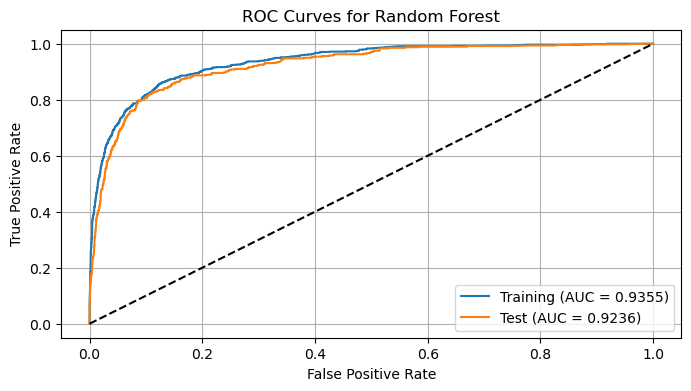

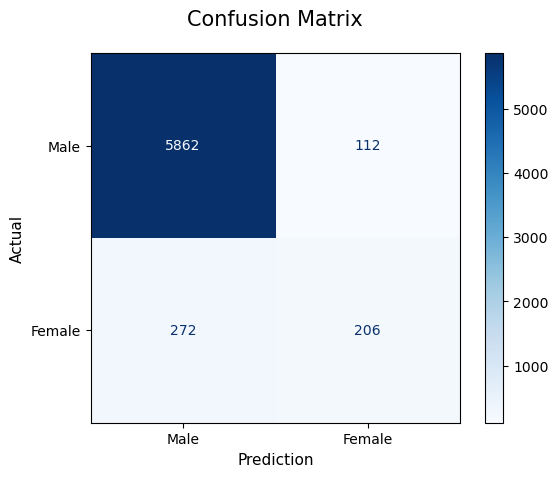

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5974
           1       0.65      0.43      0.52       478

    accuracy                           0.94      6452
   macro avg       0.80      0.71      0.74      6452
weighted avg       0.93      0.94      0.93      6452



In [41]:
calculate_metrics_training_and_test(X_train, y_train, X_test, y_test, gridsearch_rf.best_estimator_, 'ROC Curves for Random Forest')

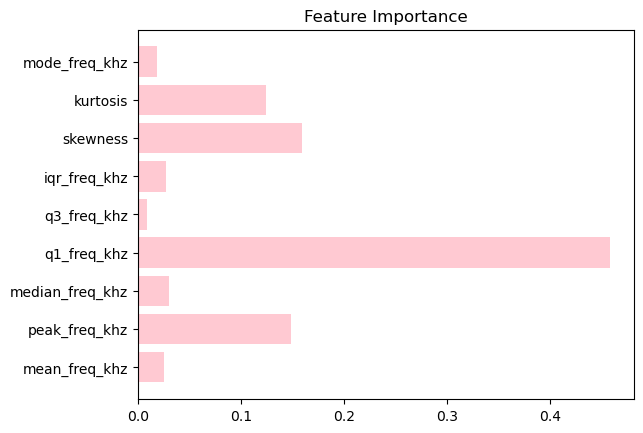

In [29]:
plt.barh(gridsearch_rf.best_estimator_.feature_names_in_, gridsearch_rf.best_estimator_.feature_importances_, alpha = 0.85, color = 'pink')
plt.title('Feature Importance')
plt.show()

#### <i> Insights:

- It seems that the classification metrics doesn't overfit that much compared to our baseline model earlier. 
- first quartile frequency has the highest feature importance to be followed by skewness and kurtosis. 


### Gradient Boosting Classifier

In [30]:
params = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.001, 0.03, 0.05],
    'max_depth': [3,5],
    'subsample': [0.6, 0.8],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'n_iter_no_change': [15, 25]
}

gbm = GradientBoostingClassifier(random_state=77)
gridsearch_cv = GridSearchCV(estimator=gbm, param_grid=params, cv = 5, verbose=3, scoring = make_scorer(f1_score, pos_label = 1, average = 'binary'))

gridsearch_cv.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=15, subsample=0.6;, score=0.000 total time=   0.9s
[CV 2/5] END learning_rate=0.001, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=15, subsample=0.6;, score=0.000 total time=   0.9s
[CV 3/5] END learning_rate=0.001, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=15, subsample=0.6;, score=0.000 total time=   0.8s
[CV 4/5] END learning_rate=0.001, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=15, subsample=0.6;, score=0.000 total time=   0.8s
[CV 5/5] END learning_rate=0.001, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=15, subsample=0.6;, score=0.000 total time=   0.8s
[CV 1/5] END learning_rate=0.001, max_depth=3, min_samples_le

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=77),
             param_grid={'learning_rate': [0.001, 0.03, 0.05],
                         'max_depth': [3, 5], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 20],
                         'n_estimators': [100, 200, 400],
                         'n_iter_no_change': [15, 25],
                         'subsample': [0.6, 0.8]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1, average=binary),
             verbose=3)

Training metrics:
Accuracy: 0.9690
AUC-ROC: 0.9759
F1-Score: 0.7628
Test metrics:
Accuracy: 0.9440
AUC-ROC: 0.9396
F1-Score: 0.5677


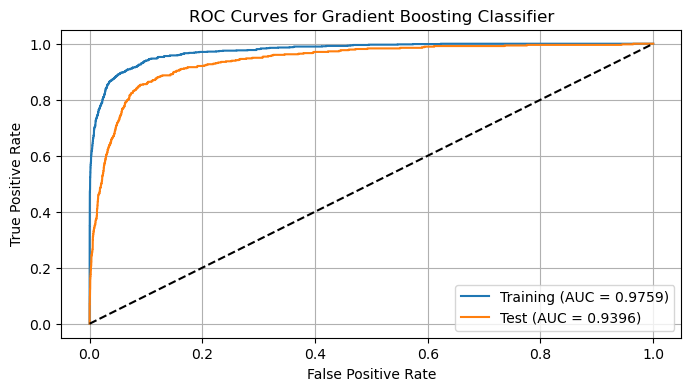

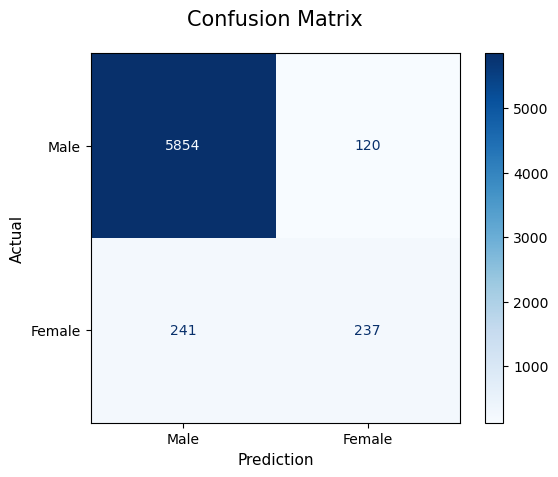

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5974
           1       0.66      0.50      0.57       478

    accuracy                           0.94      6452
   macro avg       0.81      0.74      0.77      6452
weighted avg       0.94      0.94      0.94      6452



In [42]:
calculate_metrics_training_and_test(X_train, y_train, X_test, y_test, gridsearch_cv.best_estimator_, 'ROC Curves for Gradient Boosting Classifier')

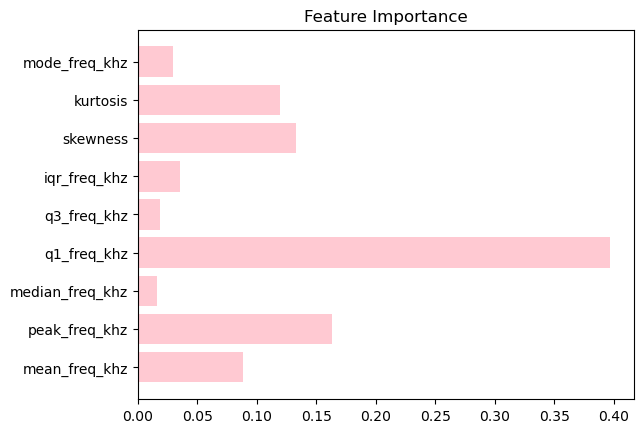

In [32]:
plt.barh(gridsearch_cv.best_estimator_.feature_names_in_, gridsearch_cv.best_estimator_.feature_importances_, alpha = 0.85, color = 'pink')
plt.title('Feature Importance')
plt.show()

#### <i> Insights:

- Looking at the f1-score, the trained model observes severe overfitting compared to Random Forest Model.
- first quartile frequency has the highest feature importance to be followed by peak frequency, skewness and kurtosis. 

In [34]:
# Best Model
gridsearch_rf.best_estimator_

RandomForestClassifier(max_depth=5, max_features=0.7, max_samples=0.9,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=120, random_state=77)

## Selecting the Best Model

<i>

- We selected our base model based on overall performance metrics, including accuracy, AUC, and F1-score. The RandomForest model outperformed the other two models.
- Despite a significant class imbalance (only 7.4% female audio data), we achieved an overall accuracy of 94% and an F1-score of 51%. The trained model also demonstrated limited overfitting.


#### Final Thoughts and Future Directions

1. Improving Data Preprocessing (Upscale the data)
2. Additional Acoustic Features: Beyond standard features (e.g., MFCCs), incorporate other voice features such as pitch, formants, spectral contrast, and chroma features. These may capture unique aspects of voice that are critical for distinguishing between classes.
3. Deep Feature Learning: Explore deep learning methods like convolutional neural networks (CNNs) to automatically learn robust features from raw audio or spectrogram representations.
4. Exploring Alternative Modeling Approaches such as SVM, Neural Networks and hybrid methods.